* [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [11]:
def y2indicator(Y, K=10):
    # K=10 for MNIST
    # Python
    N = len(Y)
    Y = Y.astype(np.int32)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, Y[i]] = 1
    return ind
    
def get_normalized_data():
    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    Y = data[:,0]
    X = data[:,1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std==0, 1)
    X = (X-mu)/std
    return X, Y

def error(p_y, T):
    predictions = np.argmax(p_y, axis=1)
    return np.mean(predictions != T)

def cost(p_y, T):
    """ Cross entropy """
    if np.any(np.isnan(np.log(p_y))):
        print("nan in log p_y")
    total = T * np.log(p_y)
    return -total.sum()

In [12]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = np.sqrt(in_dim/2.0)
    return np.random.randn(size[0],size[1]) / xavier_stddev

def derivative_W2(Z, T, Y):
    return Z.T.dot(Y-T)
                   
def derivative_b2(T, Y):
    return (Y-T).sum(axis=0)

def derivative_W1(X, Z, T, Y, W2):
    #return X.T.dot( ((Y-T).dot(W2.T) * Z * (1-Z)) )  # for sigmoid
    return X.T.dot( ((Y-T).dot(W2.T) * (Z>0)) ) # for relu

def derivative_b1(Z, T, Y, W2):
    #return ( (Y-T).dot(W2.T) * (Z*(1-Z)) ).sum(axis=0) # for sigmoid      
    return ( (Y-Y).dot(W2.T) * (Z>0) ).sum(axis=0) # for relu

def relu(a):   
    a[a<0] = 0
    return a

def sigmoid(a):
    return 1.0 / (1.0 + np.exp(-a))
    
def softmax(a):                                                                 
    a -= np.max(a) 
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

def forward(X, W1, b1, W2, b2):
    Z = relu( X.dot(W1)+b1 )
    Y = softmax( Z.dot(W2)+b2 )
    return Y, Z

In [13]:
# Input
X, Y = get_normalized_data()
Xtrain = X[:-1000,]                                                         
Ytrain = Y[:-1000]                                                          
Xtest  = X[-1000:,]                                                         
Ytest  = Y[-1000:]                                                          
Ytrain_ind = y2indicator(Ytrain)                                            
Ytest_ind = y2indicator(Ytest)

# Parameters
lr = 1.0e-5
reg = 1.0e-2
N, D = Xtrain.shape

M = 300
K=10

In [14]:
max_iter = 100
print_period = 10
batch_size = 500
n_batches = N//batch_size

# Constant Learning Rate

In [18]:
W1 = xavier_init([D, M])
b1 = np.zeros(M)
W2 = xavier_init([M, K])
b2 = np.zeros(K)

LL_batch = []
ER_batch = []
for i in range(max_iter):
    for j in range(n_batches):
        batch_range = (j*batch_size, j*batch_size + batch_size)
        
        Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
        Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]            
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)                                         
                                                                                
        # updates                                                           
        W2 -= lr*(derivative_W2(Z, Ybatch, pYbatch) + reg*W2)               
        b2 -= lr*(derivative_b2(Ybatch, pYbatch)    + reg*b2)                  
        W1 -= lr*(derivative_W1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)   
        b1 -= lr*(derivative_b1(Z, Ybatch, pYbatch, W2)         + reg*b1)           
                                                                                
    if i % print_period==0:                                           
        # calculate just for LL                                         
        pY, _ = forward(Xtest, W1, b1, W2, b2)                
        LL_batch.append( cost(pY, Ytest_ind) )                                 
        print("Cost: {}".format(LL_batch[-1]))                                                                         
        ER_batch.append( error(pY, Ytest) )                                
        print("Error:{}".format(ER_batch[-1]))                                        
                                                                                
pY, _ = forward(Xtest, W1, b1, W2, b2)                                      
print("Final error: {}".format(error(pY, Ytest)))       

Cost: 1251.5092537781877
Error:0.354
Cost: 353.2929555052721
Error:0.091
Cost: 273.6605302537232
Error:0.067
Cost: 238.81248954880232
Error:0.063
Cost: 217.82945132492006
Error:0.06
Cost: 203.4146429875939
Error:0.052
Cost: 192.71178816633713
Error:0.05
Cost: 184.25251757298074
Error:0.044
Cost: 177.2812519220934
Error:0.042
Cost: 171.33741834512142
Error:0.043
Final error: 0.044


# RMSProp

In [20]:
W1 = xavier_init([D, M])
b1 = np.zeros(M)
W2 = xavier_init([M, K])
b2 = np.zeros(K)

LL_rms = []
CR_rms = []
lr0 = 0.001 # if you set this too high you'll get NaN!
cache_W2 = 0
cache_b2 = 0
cache_W1 = 0
cache_b1 = 0
decay_rate = 0.999
eps = 0.0000000001
for i in range(max_iter):
    for j in range(n_batches):
        batch_range = (j*batch_size, j*batch_size + batch_size)
        
        Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
        Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]            
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)
            
        # updates
        gW2 = derivative_W2(Z, Ybatch, pYbatch) + reg*W2
        cache_W2 = decay_rate*cache_W2 + (1 - decay_rate)*gW2*gW2
        W2 -= lr0 * gW2 / (np.sqrt(cache_W2) + eps)

        gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
        cache_b2 = decay_rate*cache_b2 + (1 - decay_rate)*gb2*gb2
        b2 -= lr0 * gb2 / (np.sqrt(cache_b2) + eps)

        gW1 = derivative_W1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
        cache_W1 = decay_rate*cache_W1 + (1 - decay_rate)*gW1*gW1
        W1 -= lr0 * gW1 / (np.sqrt(cache_W1) + eps)

        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1
        cache_b1 = decay_rate*cache_b1 + (1 - decay_rate)*gb1*gb1
        b1 -= lr0 * gb1 / (np.sqrt(cache_b1) + eps)

    if i % print_period == 0:
        # calculate just for LL
        pY, _ = forward(Xtest, W1, b1, W2, b2)
        ll = cost(pY, Ytest_ind)
        LL_rms.append(ll)
        print("Cost: {}".format(ll))

        err = error(pY, Ytest)
        CR_rms.append(err)
        print("Error rate: {}".format(err))

pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate: {}".format(error(pY, Ytest)))

Cost: 191.38319237422394
Error rate: 0.043
Cost: 126.51929012849945
Error rate: 0.03
Cost: 120.28097729313193
Error rate: 0.029
Cost: 115.40454733763545
Error rate: 0.026
Cost: 108.12910941535625
Error rate: 0.025
Cost: 100.253955532296
Error rate: 0.023
Cost: 92.08782818508942
Error rate: 0.018
Cost: 167.07439349586022
Error rate: 0.02
Cost: 158.74111063117334
Error rate: 0.02
Cost: 149.00987262636588
Error rate: 0.021
Final error rate: 0.019


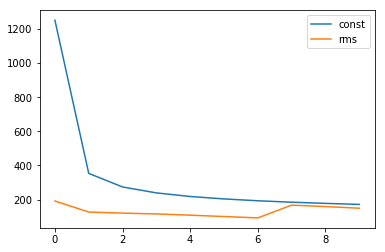

In [21]:
plt.plot(LL_batch, label='const')
plt.plot(LL_rms, label='rms')
plt.legend()
plt.show()